In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [5]:
example = mini_train_data[:1]


In [6]:
# Credit where due... some inspiration drawn from:
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/mnist.py

# example_as_pixel_matrix():
#   transforms a 784 element pixel into a 28 x 28 pixel matrix
def example_as_pixel_matrix(example):
    return np.reshape(example, (-1, 28))

# add_example_to_figure():
#   given an existing figure, number of rows, columns, and position,
#   adds a subplot with the example to the figure
def add_example_to_figure(example, 
                     figure, 
                     subplot_rows, 
                     subplot_cols, 
                     subplot_number):
    matrix = example_as_pixel_matrix(example)

    subplot = figure.add_subplot(subplot_rows, subplot_cols, subplot_number)
    subplot.imshow(matrix, cmap='Greys', interpolation='Nearest')
    # disable tick marks
    subplot.set_xticks(np.array([]))
    subplot.set_yticks(np.array([]))

# plot_examples():
#   given a matrix of examples (digit, example#) => example, 
#   plots it with digits as rows and examples as columns
def plot_examples(examples):
    
    figure = plt.figure()
    
    shape = np.shape(examples)
    rows = shape[0]
    columns = shape[1]
    
    subplot_index = 1
    
    for digit, examples_for_digit in enumerate(examples):
        for example_index, example in enumerate(examples_for_digit):
            add_example_to_figure(example, 
                                  figure, 
                                  rows, 
                                  columns, 
                                  subplot_index
                                 )
            subplot_index = subplot_index + 1
    
    figure.tight_layout()
    plt.show()

# plot_one_example():
#   given an example, plots only that example, typically
#   for debugging or diagnostics
def plot_one_example(example):  
    examples = [ [ example ] ]
    plot_examples(examples)

# select_indices_of_digit():
#   given an array of digit lables, selects the indices of
#   labels that match a desired digit
def select_indices_of_digit(labels, digit):
    return [i for i, label in enumerate(labels) if label == digit]

# take_n_from():
#   code readability sugar for taking a number of elements from an array
def take_n_from(count, array):
    return array[:count]

# take_n_examples_by_digit():
#   given a data set of examples, a label set, and a parameter n,
#   creates a matrix where the rows are the digits 0-9, and the
#   columns are the first n examples of each digit
def take_n_examples_by_digit(data, labels, n):
    examples = [
        data[take_n_from(n, select_indices_of_digit(labels, digit))]
        for digit in range(10)
    ]
    return examples

In [7]:
indices_8 = [i for i, digit in enumerate(mini_train_labels) if digit == 8]
mini_train_labels[indices_8]


array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.])

In [9]:
take_n_from(10, select_indices_of_digit(mini_train_labels, 8))

[6, 21, 23, 44, 47, 54, 70, 81, 93, 98]

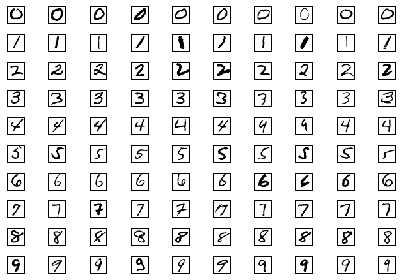

In [11]:
examples = take_n_examples_by_digit(mini_train_data, mini_train_labels, 10)
plot_examples(examples)

In [12]:
from sklearn.metrics import accuracy_score

# apply_k_nearest_neighbors():
#   given the parameter k, training data and labels, and development data and labels,
#   fit a k nearest neighbors classifier using the training data, 
#   test using development data, and output a report
def apply_k_nearest_neighbors(k,
                              training_data,
                              training_labels,
                              development_data,
                              development_labels):

    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(training_data, training_labels)
    
    predicted_labels = neigh.predict(development_data)
    
    target_names = [ str(i) for i in range(10) ]
    
    print '============ Classification report for k = ' + str(k) + ' ============'
    print ''
    print(classification_report(
            development_labels, 
            predicted_labels, 
            target_names = target_names))
    
    return accuracy_score(development_labels, predicted_labels, normalize = True)

In [13]:
def P2(k_values):
    return [
        apply_k_nearest_neighbors(k,
                                  mini_train_data,
                                  mini_train_labels,
                                  dev_data,
                                  dev_labels)
        for k in k_values
    ]

k_values = [1, 3, 5, 7, 9]
P2(k_values)

============ Classification report for k = 1 ============

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

============ Classification report for k = 3 ============

             precision    recall  f1-score   support

          0       0.90      1.00      0.95        99
          1       0.81      1.00      0.89       105
          2       0.95      0.81      0.88       102
          3       0.69      0.

[0.88800000000000001,
 0.878,
 0.86899999999999999,
 0.86499999999999999,
 0.86299999999999999]

In [14]:
print(classification_report(dev_labels, predicted, target_names = target_names))

NameError: name 'predicted' is not defined

In [169]:
target_names = { i : str(i) for i in range(10) }
target_names

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [201]:
start = time.time()


In [202]:
end = time.time()


In [203]:
end-start

2.051046133041382

In [15]:
# k_nearest_neighbors_timed_accuracy():
#   given the parameter k, training data and labels, and development data and labels,
#   fit a k nearest neighbors classifier using the training data, 
#   test using development data, and return the number of examples, prediction time,
#   and accuracy as a Python dictionary
def k_nearest_neighbors_timed_accuracy(k,
                                       training_data,
                                       training_labels,
                                       development_data,
                                       development_labels):

    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(training_data, training_labels)
    
    start = time.time()
    predicted_labels = neigh.predict(development_data)
    end = time.time()
    
    examples, dimensions = np.shape(training_data)
        
    accuracy = accuracy_score(development_labels, predicted_labels, normalize = True)
    
    return { 'examples' : examples, 'time' : end-start, 'accuracy' : accuracy }



In [215]:
k_nearest_neighbors_timed_accuracy(1, mini_train_data, mini_train_labels, dev_data, dev_labels)

{'accuracy': 0.88500000000000001, 'examples': 1000, 'time': 1.6494770050048828}

In [16]:
def P3(train_sizes, accuracies):
    k = 1
    for train_size in train_sizes:
        # sample train_size examples from the training set
        current_train_data, current_train_labels = X[:train_size], Y[:train_size]
        
        results = k_nearest_neighbors_timed_accuracy(k,
                                                     current_train_data,
                                                     current_train_labels,
                                                     dev_data,
                                                     dev_labels)
        print(results)
        accuracies.append(results['accuracy'])
        

In [17]:
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = [ ]
P3(train_sizes, accuracies)

{'accuracy': 0.71999999999999997, 'examples': 100, 'time': 0.13938307762145996}
{'accuracy': 0.78600000000000003, 'examples': 200, 'time': 0.2778639793395996}
{'accuracy': 0.84099999999999997, 'examples': 400, 'time': 0.5241100788116455}
{'accuracy': 0.88400000000000001, 'examples': 800, 'time': 1.3418858051300049}
{'accuracy': 0.90200000000000002, 'examples': 1600, 'time': 3.084074020385742}
{'accuracy': 0.92600000000000005, 'examples': 3200, 'time': 4.645766019821167}
{'accuracy': 0.93700000000000006, 'examples': 6400, 'time': 9.279623985290527}
{'accuracy': 0.95899999999999996, 'examples': 12800, 'time': 18.620343923568726}
{'accuracy': 0.96999999999999997, 'examples': 25000, 'time': 37.803242921829224}


In [18]:
from sklearn.linear_model import LogisticRegression

# fit_linear_regression():
#   given arrays of training data sizes and corresponding accuracies,
#   train and return a linear regression model for predicting accuracies
def fit_linear_regression(train_sizes, accuracies):
    train_sizes_matrix = [ [ train_size ] for train_size in train_sizes ]
    
    linear = LinearRegression()
    linear.fit(train_sizes_matrix, accuracies)
    
    return linear

# fit_logistic_regression():
#   given arrays of training data sizes and corresponding accuracies,
#   train and return a logistic regression model for predicting accuracies
def fit_logistic_regression(train_sizes, accuracies):
    train_sizes_matrix = [ [ train_size ] for train_size in train_sizes ]
    
    logistic = LogisticRegression()
    logistic.fit(train_sizes_matrix, accuracies)
    
    return logistic

In [19]:
def P4():
    full_training_size = 60000
    
    linear = fit_linear_regression(train_sizes, accuracies)
    linear_prediction = linear.predict(full_training_size)
    print('Linear model prediction for ' 
          + str(full_training_size) + ' : ' + str(linear_prediction[0]))
    
    logistic = fit_logistic_regression(train_sizes, accuracies)
    logistic_prediction = logistic.predict(full_training_size)
    print('Logistic model prediction for ' 
          + str(full_training_size) + ' : ' + str(logistic_prediction[0]))
    
P4()

Linear model prediction for 60000 : 1.24307226036
Logistic model prediction for 60000 : 0.97


In [20]:
# train_k_nearest_neighbors():
#   given the parameter k, training data and labels, and development data and labels,
#   fit a k nearest neighbors classifier using the training data
def train_k_nearest_neighbors(k,
                              training_data,
                              training_labels):

    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(training_data, training_labels)
    
    return neigh

# most_confused():
#   given a confusion matrix
#   returns a sequence that comprises the two most confused digits, and errors between them
def most_confused(confusion):
    rows, columns = np.shape(confusion)
    worst_row, worst_column, worst_errors = 0, 1, 0
    
    # iterate through the upper triangle, ignoring the diagonals
    # confused is the sum for each pair of indices
    for row in range(rows):
        for column in range(row + 1, columns):
            errors = confusion[row][column] + confusion[column][row]
            if errors > worst_errors:
                worst_row, worst_column, worst_errors = row, column, errors
    
    return ( worst_row, worst_column, worst_errors )

# select_pairwire_error_indices():
#   given a predictions vector, actual label vector, and the digits of interest
#   returns an array of indices where the digits were confused
def select_pairwire_error_indices(predictions, labels, confused_low, confused_high):
    error_indices = [ ]
    for i, prediction in enumerate(predictions):
        label = labels[i]
        if ((prediction == confused_low and label == confused_high) or
            (prediction == confused_high and label == confused_low)):
            
            error_indices.append(i)
            
    return error_indices

Most confused digits are: 3 and 8, with 3 total confusion errors


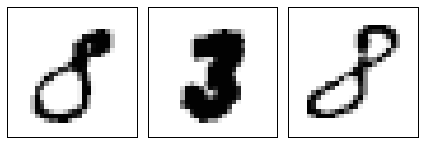

array([[ 99,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  98,   2,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,  83,   0,   1,   0,   0,   1,   1],
       [  0,   0,   0,   0, 102,   0,   0,   0,   0,   2],
       [  1,   0,   0,   0,   0,  88,   0,   0,   1,   1],
       [  1,   0,   0,   0,   1,   0,  96,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0, 111,   0,   1],
       [  1,   0,   1,   2,   0,   2,   1,   0,  89,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 106]])

In [21]:
def P5():
    k = 1
    neigh = train_k_nearest_neighbors(k, train_data, train_labels)
    development_predicted = neigh.predict(dev_data)
    
    confusion = confusion_matrix(dev_labels, development_predicted)
    
    confused_low, confused_high, confusion_errors = most_confused(confusion)
    print('Most confused digits are: ' + str(confused_low) + ' and ' + str(confused_high)
          + ', with ' + str(confusion_errors) + ' total confusion errors')
    
    error_indices = select_pairwire_error_indices(
    development_predicted, dev_labels, confused_low, confused_high)
    error_examples = [ dev_data[error_indices] ]
    plot_examples(error_examples)
    
    return confusion
P5()

In [22]:
neigh = train_k_nearest_neighbors(1, train_data, train_labels)

In [23]:
development_predicted = neigh.predict(dev_data)

In [24]:
confusion = confusion_matrix(dev_labels, development_predicted)

In [25]:
confused_low, confused_high, confusion_errors = most_confused(confusion)
print('Most confused digits are: ' + str(confused_low) + ' and ' + str(confused_high)
      + ', with ' + str(confusion_errors) + ' total confusion errors')

Most confused digits are: 3 and 8, with 3 total confusion errors


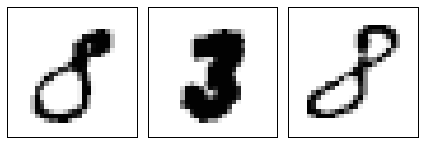

In [26]:
error_indices = select_pairwire_error_indices(
    development_predicted, dev_labels, confused_low, confused_high)
error_examples = [ dev_data[error_indices] ]
plot_examples(error_examples)


In [27]:
np.shape(example)

(1, 784)

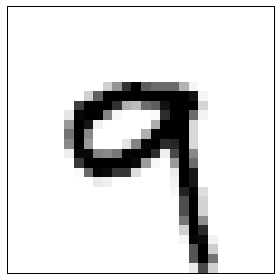

In [28]:
error_example = dev_data[561:562]
np.shape(error_example)
plot_one_example(error_example)

In [31]:
import itertools

def blur(image):
    pixel_matrix = example_as_pixel_matrix(image)
    blurred_image = []
    rows, columns = np.shape(pixel_matrix)
    
    for row in range(rows):
        for column in range(columns):
            # take the mean of the 9-pixel neighborhood (in clause)
            # but guard against running off the edges of the matrix (if clause)
            value = np.mean(list( 
                pixel_matrix[i][j] 
                for i, j
                in itertools.product(
                    range(row - 1, row + 2), 
                    range(column - 1, column + 2)
                )
                if (i >= 0) and (j >= 0) and (i < rows) and (j < columns)
            ))
            
            blurred_image.append(value)
    
    return blurred_image
    

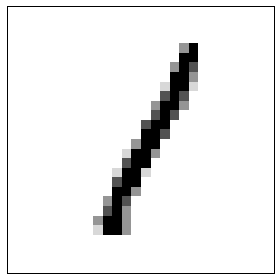

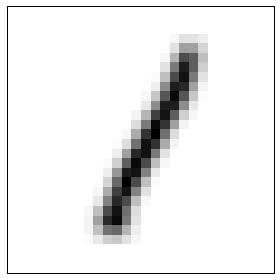

In [34]:
example = mini_train_data[:1]
plot_one_example(example)
plot_one_example(blur(example))

In [35]:
blurred_mini_train_data = [ blur(datum) for datum in mini_train_data ]

In [37]:
np.shape(mini_train_data)

(1000, 784)

In [38]:
np.shape(blurred_mini_train_data)

(1000, 784)

In [39]:
np.shape(train_data)

(60000, 784)

In [32]:
blurred_training_data = [ blur(example) for example in train_data ]
np.shape(blurred_training_data)


KeyboardInterrupt: 

In [316]:
np.shape(blurred_training_data)

(1000, 784)

In [303]:
row, column = 1, 2

import itertools
pixel_matrix = example_as_pixel_matrix(example)
rows, columns = np.shape(pixel_matrix)
value = np.mean(list( 
    pixel_matrix[i][j] 
    for i, j
    in itertools.product(
        range(row - 1, row + 2), 
        range(column - 1, column + 2)
    )
    if (i >= 0) and (j >= 0) and (i < rows) and (j < columns)
))

value

np.mean(list( 
    pixel_matrix[i][j] 
    for i, j
    in itertools.product(
        range(row - 1, row + 2), 
        range(column - 1, column + 2)
    )
    if (i >= 0) and (j >= 0) and (i < rows) and (j < columns)
))


0.0

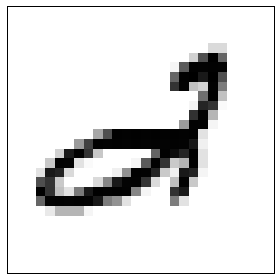

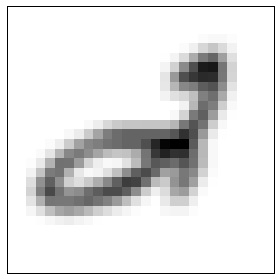

In [314]:
blurred_example = blur(example)
plot_one_example(example)
plot_one_example(blurred_example)

In [308]:
np.shape(example_as_pixel_matrix(blurred_example))

(28, 28)

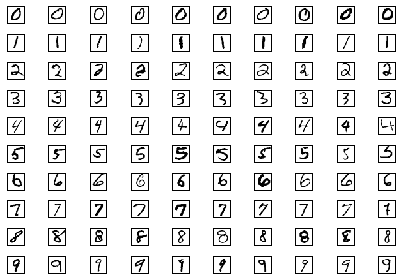

In [317]:
plot_examples(take_n_examples_by_digit(train_data, train_labels, 10))

In [1]:
blurred_training_data = [ blur(example) for example in train_data ]
plot_examples(take_n_examples_by_digit(blurred_training_data, train_labels, 10))

NameError: name 'train_data' is not defined

In [2]:
blurred_training_data = [ blur(example) for example in train_data ]

NameError: name 'train_data' is not defined

In [3]:
# binarize_example():
#   Turn all pixels below 0.5 (or threshold) -> 0, greater -> 1
def binarize_example(example, threshold = 0.5):
    binarized = [ 1 if value > threshold else 0 for value in example ]
    return binarized
    
# binarize_examples():
#   Apply binarization to a set of example
def binarize_examples(examples, threshold = 0.5):
    binarized = [ binarize_example(example, threshold) for example in examples ]
    return binarized

# ternarize_example():
#   Turn all pixels below 1/3 (or threshold) -> 0, 1/3 through 2/3 -> 1, greater -> 2
def ternarize_example(example, threshold_low = 0.33333333, threshold_high = 0.66666666):
    ternarized = [ 
        0 if value < threshold_low else 1 if value < threshold_high else 2
        for value in example
    ]
    return ternarized

# ternarize_examples():
#   Apply ternarization to a set of example
def ternarize_examples(examples, threshold_low = 0.33333333, threshold_high = 0.66666666):
    ternarized = [ 
        ternarize_example(example, threshold_low, threshold_high) 
        for example in examples 
    ]
    return ternarized

In [10]:
binarized_train_data = binarize_examples(train_data)

In [53]:
ternarized_train_data = ternarize_examples(train_data)

In [55]:
binary_naive_bayes = BernoulliNB()
binary_naive_bayes.fit(binarized_train_data, train_labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [64]:
ternary_naive_bayes = MultinomialNB()
ternary_naive_bayes.fit(ternarized_train_data, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
binarized_dev_data = binarize_examples(dev_data)

In [63]:
ternarized_dev_data = ternarize_examples(dev_data)

In [57]:
binary_naive_bayes_predicted = binary_naive_bayes.predict(binarized_dev_data)

In [65]:
ternary_naive_bayes_predicted = ternary_naive_bayes.predict(ternarized_dev_data)

In [61]:
    target_names = [ str(i) for i in range(10) ]
    print '============ Classification report for binarized ============'
    print ''
    print(classification_report(
            dev_labels, 
            binary_naive_bayes_predicted, 
            target_names = target_names))
    print ' Accuracy score: '
    print(accuracy_score(dev_labels, binary_naive_bayes_predicted, normalize = True))

============ Classification report for binarized ============

             precision    recall  f1-score   support

          0       0.94      0.98      0.96        99
          1       0.86      0.95      0.90       105
          2       0.88      0.79      0.84       102
          3       0.70      0.76      0.73        86
          4       0.86      0.83      0.84       104
          5       0.88      0.77      0.82        91
          6       0.91      0.88      0.89        98
          7       0.93      0.82      0.87       113
          8       0.75      0.82      0.79        96
          9       0.76      0.83      0.79       106

avg / total       0.85      0.84      0.85      1000

 Accuracy score: 
0.845


In [66]:
    print '============ Classification report for ternarized ============'
    print ''
    print(classification_report(
            dev_labels, 
            ternary_naive_bayes_predicted, 
            target_names = target_names))
    print ' Accuracy score: '
    print(accuracy_score(dev_labels, ternary_naive_bayes_predicted, normalize = True))

============ Classification report for ternarized ============

             precision    recall  f1-score   support

          0       0.92      0.97      0.95        99
          1       0.89      0.93      0.91       105
          2       0.86      0.78      0.82       102
          3       0.75      0.76      0.75        86
          4       0.87      0.75      0.80       104
          5       0.88      0.69      0.77        91
          6       0.91      0.88      0.89        98
          7       0.96      0.79      0.86       113
          8       0.65      0.83      0.73        96
          9       0.68      0.86      0.76       106

avg / total       0.84      0.83      0.83      1000

 Accuracy score: 
0.826


In [69]:
foo = (
    [ 1, 2 ] +
    [3, 4] +
    [5, 6]
)
foo

[1, 2, 3, 4, 5, 6]

In [4]:
def P7():
    binarized_train_data = binarize_examples(train_data)
    ternarized_train_data = ternarize_examples(train_data)
    



In [6]:
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]} 

In [7]:
bernoulli_naive_bayes = BernoulliNB()

In [9]:
grid_search = GridSearchCV(bernoulli_naive_bayes, alphas, verbose = 3)

In [11]:
grid_search.fit(binarized_train_data, train_labels)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] alpha=0.0 .......................................................
[CV] .............................. alpha=0.0, score=0.098940 -   7.0s

//anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:534: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    7.0s



[CV] alpha=0.0 .......................................................
[CV] .............................. alpha=0.0, score=0.098900 -   7.9s
[CV] alpha=0.0 .......................................................
[CV] .............................. alpha=0.0, score=0.098910 -   6.4s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.838966 -   5.2s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.838650 -   6.1s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.833083 -   8.2s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.838666 -   5.0s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.838500 -   5.3s
[CV] 

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.9min finished


GridSearchCV(cv=None,
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [13]:
grid_search.best_params_



{'alpha': 0.0001}